# CREANDO VALOR DE NEGOCIO CON DATA SCIENCE

# Parte 2 - Zillow Zestimate: Exploratory Data Analysis (I)

## Imports

Importamos las librerias con las que vamos a realizar el Análisis Exploratorio de Datos:

**numpy** --> Usado para operaciones matemáticas y lógicas con nuestros datos

**pandas** --> Usado para el almacenamiento y manejo básico de nuestros datos

**matplotlib** --> Usado para la visualización de datos, creación de gráficos, etc.

**seaborn** --> Usado para algunas visualizaciones de datos más complejas de las que maneja matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Vamos a comenzar revisando los archivos de nuestra carpeta de datos para ver con qué estamos trabajando:

`20/06/2018  05:40       648.820.905 properties_2016.csv
20/06/2018  05:40       650.093.621 properties_2017.csv
20/06/2018  05:40        62.696.830 sample_submission.csv
20/06/2018  05:40         2.452.454 train_2016_v2.csv
20/06/2018  05:40         2.822.022 train_2017.csv
20/06/2018  05:40            19.229 zillow_data_dictionary.xlsx`

Parece que disponemos de datos tanto para el 2016 como para el 2017. De la página de datos de la competición obtenemos las descripción de los ficheros:

* **properties_2016.csv**: todas las propiedades con sus características para 2016. Nota: Algunas propiedades nuevas de 2017 aún no tienen datos excepto sus *parcelid's*. Esos datos deberán rellenarse cuando el archivo *properties_2017.csv* esté disponible.
* **properties_2017.csv**: todas las propiedades con sus características para 2017 (publicado el 2/10/2017).
* **train_2016_v2.csv**: conjunto de entrenamiento con transacciones desde el 1/1/2016 al 31/12/2016.
* **train_2017.csv**: conjunto de entrenamiento con transacciones desde 1/1/2017 al 15/9/2017 (publicado el 2/10/2017).
* **sample_submission.csv**: un fichero de entrega de ejemplo en el formato correcto.

Vamos a empezar con el fichero de datos de 2016 dado que está completamente poblado. Lo leeremos en un dataframe de Pandas, que nos permitirá manejarlo fácilmente y explorar todos estos datos.

In [2]:
train_df = pd.read_csv("./data/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.head(10)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02
6,12286022,0.0440,2016-01-02
7,17177301,0.1638,2016-01-02
8,14739064,-0.0030,2016-01-02
9,14677559,0.0843,2016-01-03


Cargamos el DataFrame a partir del csv, con la opción **`parse_dates`**, para asegurarnos que la columna **`transactiondate`** sea del tipo `datetime`. Comprobamos que tiene el tipo correcto:

In [3]:
train_df.dtypes

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object

Como vemos, el DataFrame se compone de 3 columnas: un ID, la fecha de transacción y el **logerror**. El **logerror** es nuestro valor target, el valor que queremos predecir, definido como el error logarítmico (*log-error*) entre la estimación Zillow y el precio de venta real.

**logerror = log(Zestimate)−log(Precio de Venta)**

Entonces, en pocas palabras, queremos predecir cuán preciso es el sistema Zestimate de Zillow para predecir el valor de una vivienda dada con los datos proporcionados. Desde una perspectiva de negocio, esto nos permitiría saber si para una casa en particular el sistema Zestimate tendrá un buen desempeño o un desempeño deficiente. En el futuro podremos mejorar el el algoritmo Zestimate centrándonos en los puntos débiles.

Vamos a ver cuáles son las dimensiones de nuestro DataFrame:

In [4]:
train_df.shape

(90275, 3)

Para comenzar con nuestro Análisis Exploratorio de Datos (EDA, en inglés) echemos un vistazo a la distribución del logerror, para ver cómo deberíamos abordar esto en general.

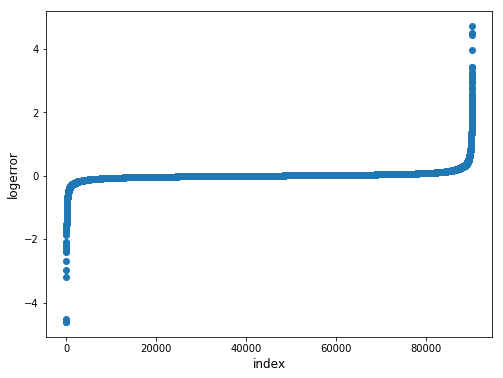

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df["logerror"].values))
plt.xlabel("index", fontsize=12)
plt.ylabel("logerror", fontsize=12)
plt.show()

Parece que la gran mayoría de las veces, el error es muy bajo y está cercano a cero. Eso significa que nuestro modelo funciona bastante bien en general, pero hay una serie de valores atípicos que parecen producir la mayoría de los errores. Estos pueden justificar prestarles una atención específica más adelante.

Aún no podemos ver los errores exactos de la mayoría de los datos (en el medio) ya que todo está muy cerca de cero. Eliminemos los valores atípicos y luego hagamos un gráfico de histograma para poder ver más claramente cómo se distribuye la mayoría:

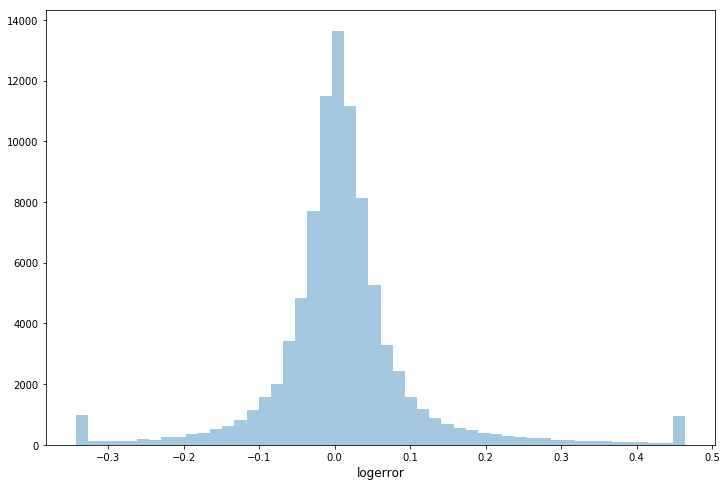

In [6]:
ulimit = np.percentile(train_df["logerror"].values, 99)  # Calculamos cuál es el percentil 99
llimit = np.percentile(train_df["logerror"].values, 1)   # Calculamos cuál e sel percentil 1
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit  # Todas las líneas de logerror superiores a percentil 99 le asignamos ese valor
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit  # Todas las líneas de logerror inferiores a percentil 1 le asignamos ese valor

plt.figure(figsize=(12,8))
sns.distplot(train_df["logerror"].values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

¡Increible! Es una bonita y limpia distribución normal. La mayoría de los errores se concentran alrededor del cero. Nuestro objetivo será ajustar aún más este gráfico (comprimirlo hacia adentro desde los lados) y eliminar esos valores atípicos.

## Fecha de transacción

Ahora exploremos el campo fecha. Quizás las personas compren y vendan casas en la misma época del año. Revisemos el número de transacciones en cada mes.

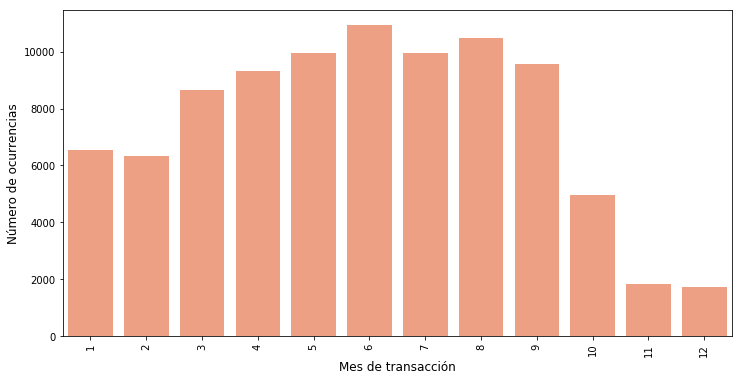

In [7]:
# Creamos una nueva columna con el nº de mes a partir de la columna con la fecha de transacción
train_df['transaction_month'] = train_df['transactiondate'].dt.month
# Devuelve una serie con el nº de ocurrencias de cada valor único (en este caso, las ocurrencias de cada mes)
cnt_srs = train_df['transaction_month'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color="coral")
plt.xticks(rotation='vertical')
plt.xlabel('Mes de transacción', fontsize=12)
plt.ylabel('Número de ocurrencias', fontsize=12)
plt.show()

Como se indicó anteriormente, los datos de entrenamiento contienen todas las transacciones anteriores al 15/10/2016 y sólo algunas de las posteriores al 15/10/2016. Por eso tenemos barras más cortas en los últimos tres meses. Dicho esto, parece que la mayoría de las compras se concentran alrededor del medio. La gente tendería a comprar casas durante los meses de verano. Más personas de vacaciones, los niños fuera del colegio y, en general, menor tiempo de tráfico y menor presión.

Por último, vamos a echar un vistazo rápido a los IDs. Si no existen muchos duplicados, deduciremos que la mayoría de las casas sólo se compran y se venden una vez en este periodo de 2016 a 2017.

## Id de parcela

In [8]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

La mayoría de los IDs aparecen sólo una vez, por lo que la mayoría de las casas se han comprado/vendido sólo una vez en este periodo de tiempo. Curiosamente, todavía hay un buen número que fueron compradas/vendidas dos veces.

## Propiedades 2016

Bien, ahora que tenemos una visión a alto nivel de nuestro objetivo, podemos empezar a analizar los datos y las características con las que tenemos que rabajar. Echar un vistazo rápido a la cabecera nos da siempre una idea bastante clara del tipo de datos con los que trabajamos para cada una de las características.

In [9]:
prop_df = pd.read_csv("./data/properties_2016.csv")
prop_df.shape

c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [10]:
prop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

Parece que hay muchos `float`, por lo que no tendremos que realizar mucha transformación, como tendríamos que hacer con datos categóricos. Los datos ocupan más de 1,3 GB, por lo que es mejor que nos aseguremos que tenemos suficiente memoria RAM disponible.

In [11]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


Es por esto por lo que hacer un `head()` es siempre útil. ¡Muchas de nuestras columnas tienen valores `NaN` para las primeras 10 líneas! Eso parece sospechoso... así que primero investiguemos esos NaN's para que no nos despisten más tarde. Comprobaremos cuantos NaN's hay en cada columna.

In [12]:
missing_df = prop_df.isna().sum(axis=0).reset_index()
missing_df.columns = ["column_name", "missing_count"]
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

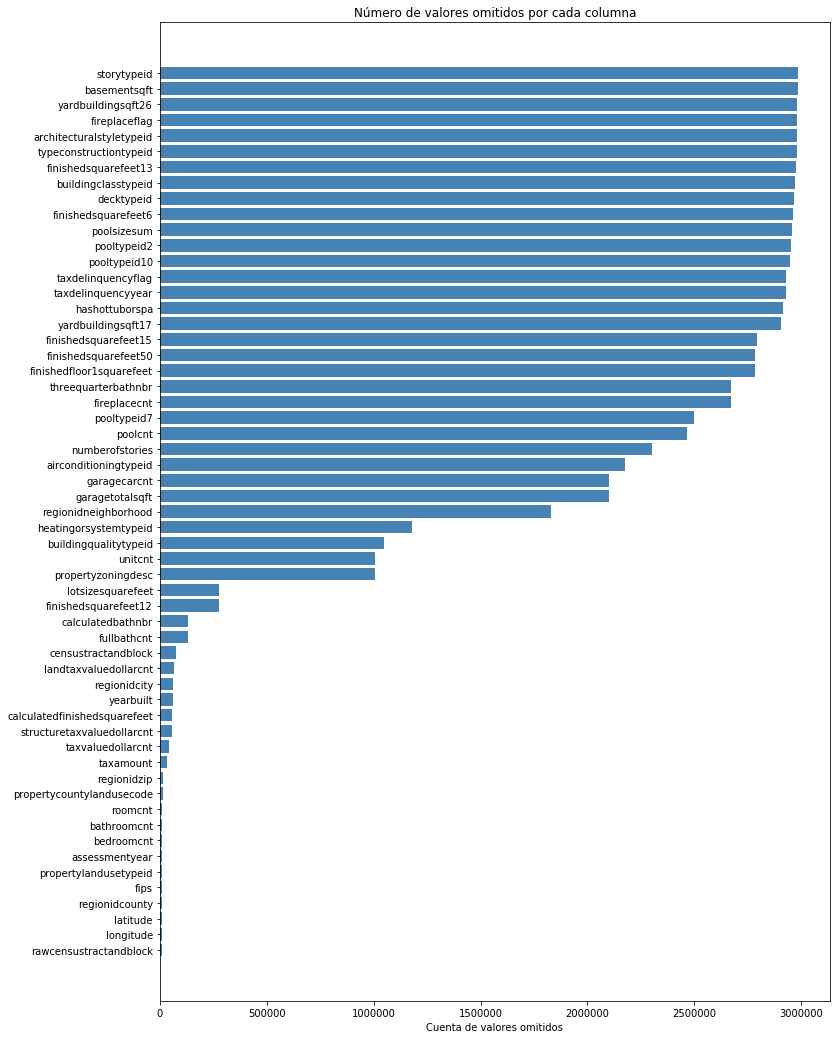

In [13]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fix, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df["missing_count"].values, color="steelblue")
ax.set_yticks(ind)
ax.set_yticklabels(missing_df["column_name"].values, rotation="horizontal")
ax.set_xlabel("Cuenta de valores omitidos")
ax.set_title("Número de valores omitidos por cada columna")
plt.show()

¡Muchos NaN's!

Dado que estos datos son del estado de California, algunos de estos son comprensibles. Por ejemplo, muchas casas en California no tienen sótanos ya que el clima es bastante cálido, por lo que tiene sentido que tengamos NaN's para la característica sótano (*`basementsqft`*). No todas tendrán piscina, por lo que todo lo relacionado con piscina tendrá igualmente muchos NaN's. Es estupendo comprobar que muchas de las variables útiles están intactas, como el número de dormitorios (*`bedroomcnt`*), número de baños (*`bathroomcnt`*) y número de habitaciones (*`roomcnt`*).

También faltan algunas de las características de más grano fino. Por ejemplo, los pies cuadrados de cada piso/sección de la vivienda faltan muchos, pero los pies cuadrados totales no faltan demasiados. Esperemos que el total de pies cuadrados sea suficiente para englobar el valor de los otros más específicos.

Ahora que sabemos qué características son en su mayoría NULL y cuáles están bien pobladas, podemos enfocar nuestro EDA en las más completas, ya que de todos modos las características con muchos NaN's no nos van a proporcionar una imagen muy precisa de nuestros datos.

## Análisis univariante

Antes de nada, unamos nuestros datos de entrenamiento y de propiedades.

In [14]:
# Unimos el df de entrenamiento y el de propiedades, tomando como columna clave "parcelid", left outer join
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Comencemos observando sólo las variables "`float`" y luego obtengamos la correlación con el target "logerror" para ver cómo están relacionadas. Este análisis de correlación nos dará una buena idea de qué variables serán las más efectivas para predecir nuestro resultado.

In [30]:
# Para calcular los coeficientes de correlación vamos a completar los valores nulos con valores medios
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

# Calculamos el coeficiente de correlación para cada una de esas variables
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new["logerror"].values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

c:\program files\python37\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\program files\python37\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


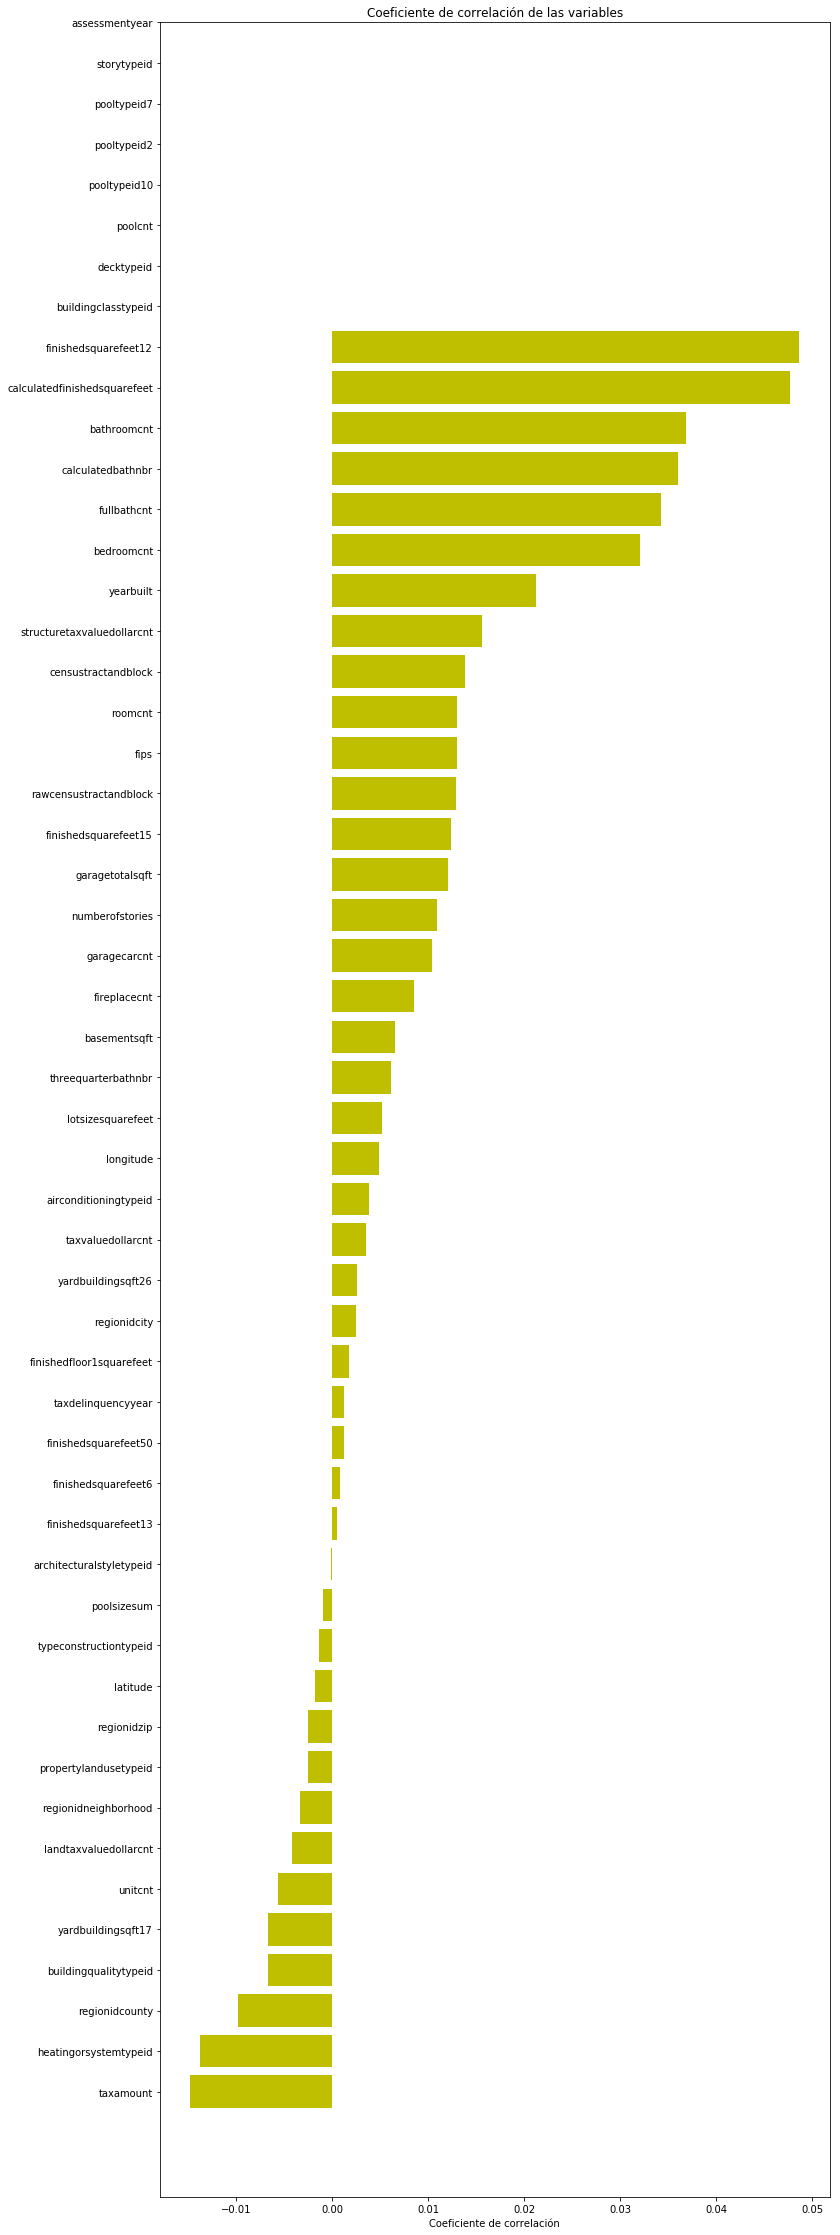

In [34]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Coeficiente de correlación")
ax.set_title("Coeficiente de correlación de las variables")
#autolabel(rects)
plt.show()

¡Fantástico! Hay abundante información en el gráfico anterior.

Los 4 elementos más correlacionados con nuestro logerror son el número de pies cuadrados de nuestra casa, el número de cuartos de baño, el número de habitaciones y el año de construcción. Desde una perspectiva de negocio podemos decir que las casas con más pies cuadrados, baños y habitaciones parecen producir un error mayor. Esto puede tener sentido si pensamos en el hecho de que tales casas serían más caras, por lo tanto, en general, menos ventas, ¡lo que también nos deja con menos datos para trabajar con los hogares en ese rango de precios! El año de construcción es parecido, ya que tendremos menos datos para las ventas más recientes simplemente por el tiempo.

Parece que la ciudad donde se encuentra la vivienda no tiene mucho efecto en el error de nuestro sistema Zestimate, curiosamente. PERO el condado en el que se encuentra la casa tiene una fuerte correlación negativa, al igual que los impuestos.

In [44]:
# Seleccionamos las variables con las mayores correlaciones
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.005)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
33,regionidcounty,-0.009844
6,buildingqualitytypeid,-0.006648
41,yardbuildingsqft17,-0.006643
40,unitcnt,-0.005685
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
